In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import sys
print(sys.executable)

/Users/adminpc-macmini/Documents/Code/Libaries/python_jupyter_venv/bin/python


In [3]:
!jupyter kernelspec list

Available kernels:
  python3    /Users/adminpc-macmini/Documents/Code/Libaries/python_jupyter_venv/share/jupyter/kernels/python3


In [4]:
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from skimage import color
from skimage import io
from skimage.transform import resize

2023-12-05 22:30:19.198559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
ROOT_FILE_PATH = "/Volumes/ESD-USB/files/2023-Machine-Learning-Dataset"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [7]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])

In [8]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [9]:
class ReadObject:
  
  fmri = None           # dict(string -> ndarray, float32)
  masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  image_labels = None   # dataframe
  label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode = "train"):
    
    self.image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    self.image_labels = self.image_labels.drop(self.image_labels.columns[[0, 1]], axis=1)
    self.label_names = self.image_labels.columns
    
    self.image_labels = self.image_labels.to_numpy(dtype=int)

    print('Images: ' + str(self.image_labels.shape[0]))
    print('Labels: ' + str(self.image_labels.shape[1]))
    
    self.masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    print('Masks: ' + str(len(self.masks.keys())))
        
    if mode == "train":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
    elif mode == "test":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))

  def split_data(self, count=None, ratio=None, permutate=True, image_mode = "rgb", random_state=42):
    
    if ratio is None:
      ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_copy = self.fmri['l'][:count]
      fmri_r_copy = self.fmri['r'][:count]
      labels_copy = self.image_labels[:count]
    else:
      fmri_l_copy = self.fmri['l']
      fmri_r_copy = self.fmri['r']
      labels_copy = self.image_labels
    
    loaded_images = np.stack([FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject,
                      "training_split", "training_images"), i, mode = image_mode) for i in range(labels_copy.shape[0])])
    
    if permutate:
      
        idx = random_state.permutation(labels_copy.shape[0])
        
        fmri_l_copy = fmri_l_copy[idx]
        fmri_r_copy = fmri_r_copy[idx]
        labels_copy = labels_copy[idx]
        loaded_images = loaded_images[idx]
        
    train_size = int(labels_copy.shape[0] * ratio)
  
    fmri_l_train = fmri_l_copy[0:train_size]
    fmri_r_train = fmri_r_copy[0:train_size]
    labels_train = labels_copy[0:train_size]
    images_train = loaded_images[0:train_size]
    
    fmri_l_val = fmri_l_copy[train_size:]
    fmri_r_val = fmri_r_copy[train_size:]
    labels_val = labels_copy[train_size:]
    images_val = loaded_images[train_size:]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val)

In [10]:
%matplotlib inline
def test_data(label_names, labels_list, image, fmri_l, fmri_r):
  labels = np.array(label_names)[np.where(labels_list != 0)] 
  print(labels)
  plt.imshow(image, cmap='gray')
  plt.show()

In [11]:
SUBJ_LIST = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]

In [12]:
def min_max_normalize(X, min=0, max=1):
  
  # Define the original range
  old_min = np.min(X)
  old_max = np.max(X)
  
  # Map the values from the original range to the new range
  X = (np.array(X, dtype='float32') - old_min) * (max - min) / (old_max - old_min) + min
  
  return X

In [13]:
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None

subject_count = 2

image_mode = "gray"

for sub in SUBJ_LIST[:subject_count]:
  
  print(sub)
  
  sub_obj = ReadObject(sub)
  sub_obj.load()
  
  global_labels_name = sub_obj.label_names if global_labels_name is None else global_labels_name
  
  (
    (labels_train, labels_val), (fmri_l_train, fmri_l_val),
    (fmri_r_train, fmri_r_val), (images_train, images_val)
  ) = (sub_obj.split_data(count=5000, ratio=0.995, image_mode=image_mode))
  
  print(f"labels_train  shape: {labels_train.shape}")
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))
  
  print(f"labels_val  shape: {labels_val.shape}")
  global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))
  
  fmri_l_train = min_max_normalize(fmri_l_train)
  print(f"fmri_l_train  shape: {fmri_l_train.shape} | min: {np.min(fmri_l_train)} max: {np.max(fmri_l_train)}")
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))
  
  fmri_l_val = min_max_normalize(fmri_l_val)
  print(f"fmri_l_val  shape: {fmri_l_val.shape} | min: {np.min(fmri_l_val)} max: {np.max(fmri_l_val)}")
  global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))
  
  fmri_r_train = min_max_normalize(fmri_r_train)
  print(f"fmri_r_train  shape: {fmri_r_train.shape} | min: {np.min(fmri_r_train)} max: {np.max(fmri_r_train)}")
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))
  
  fmri_r_val = min_max_normalize(fmri_r_val)
  print(f"fmri_r_val  shape: {fmri_r_val.shape} | min: {np.min(fmri_r_val)} max: {np.max(fmri_r_val)}")
  global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))
  
  if image_mode == 'rgb':
    images_train = min_max_normalize(images_train)
  elif image_mode == 'gray':
    images_train = images_train.reshape((-1, images_train.shape[1], images_train.shape[2], 1))
  print(f"images_train  shape: {images_train.shape} | min: {np.min(images_train)} max: {np.max(images_train)}")
  global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))
  
  if image_mode == 'rgb':
    images_val = min_max_normalize(images_val)
  elif image_mode == 'gray':
    images_val = images_val.reshape((-1, images_val.shape[1], images_val.shape[2], 1))
  print(f"images_val  shape: {images_val.shape} | min: {np.min(images_val)} max: {np.max(images_val)}")
  global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))

subj01
Images: 5000
Labels: 133
Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0
images_train  shape: (4975, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (25, 425, 425, 1) | min: 0.0 max: 1.0
subj02
Images: 5000
Labels: 133
Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0
images_train  shape: (4975, 425, 425, 1) | min: 0.0 max: 1.0
images_val  shape: (25, 425, 425, 1) | min: 0.0 max: 1.0


In [14]:
print('Global shapes:')
print(global_labels_train.shape)
print(global_labels_val.shape)
print(global_fmri_l_train.shape)
print(global_fmri_l_val.shape)
print(global_fmri_r_train.shape)
print(global_fmri_r_val.shape)
print(global_images_train.shape)
print(global_images_val.shape)

Global shapes:
(9950, 133)
(50, 133)
(9950, 19004)
(50, 19004)
(9950, 20544)
(50, 20544)
(9950, 425, 425, 1)
(50, 425, 425, 1)


Label test 184:
['person' 'cup' 'tv' 'laptop' 'cell phone' 'vase' 'scissors'
 'mirror-stuff' 'shelf' 'table-merged' 'paper-merged' 'wall-other-merged']


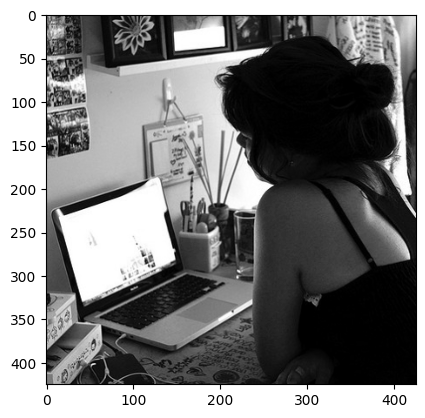

In [15]:
label_test_index = 184
print(f'Label test {label_test_index}:')
test_data(global_labels_name, global_labels_train[label_test_index], global_images_train[label_test_index], None, None)

In [16]:
print(f'Combined fmri data train:')
print(global_fmri_l_train.shape)
print(global_fmri_r_train.shape)
global_X_train = np.concatenate((global_fmri_l_train, global_fmri_r_train), axis=1)

print(global_X_train.shape)

print(f'Combined fmri data val:')

print(global_fmri_l_val.shape)
print(global_fmri_r_val.shape)
global_X_val  = np.concatenate((global_fmri_l_val, global_fmri_r_val), axis=1)

print(global_X_val.shape)

Combined fmri data train:
(9950, 19004)
(9950, 20544)
(9950, 39548)
Combined fmri data val:
(50, 19004)
(50, 20544)
(50, 39548)


In [17]:
print(f'Global labels:')
global_Y_train_classification = global_labels_train
print(global_Y_train_classification.shape)

Global labels:
(9950, 133)


In [18]:
from tensorflow import keras

# Image classification

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(filters=32, kernel_size=(5,), input_shape=(39548, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=32, kernel_size=(5,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Conv1D(filters=64, kernel_size=(4,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=64, kernel_size=(4,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(133, activation="softmax"))

model.compile(
  optimizer= keras.optimizers.SGD(learning_rate=0.00001), loss= keras.losses.CategoricalCrossentropy(), 
  metrics= [keras.metrics.CategoricalAccuracy()]) 

model.summary()

In [ ]:
history = model.fit(global_X_train.reshape(-1, global_X_train.shape[1], 1), global_labels_train, 
                    validation_data=(global_X_val, global_labels_val), batch_size=64, epochs=10)

In [ ]:
# Accessing training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Printing training and validation loss and accuracy
for i in range(len(training_loss)):
    print(f"Epoch {i+1}: Training Loss: {training_loss[i]}, Training Accuracy: {training_accuracy[i]}, Validation Loss: {validation_loss[i]}, Validation Accuracy: {validation_accuracy[i]}")

In [ ]:
prediction_model = model.predict(global_X_val.reshape(-1, global_X_train.shape[1], 1))
print(prediction_model.shape)

In [ ]:
prediction_model_index = 16
test_data(global_labels_name, global_labels_val[prediction_model_index], global_images_val[prediction_model_index], None, None)

In [ ]:
label_count = 3
print(prediction_model[prediction_model_index])
top_3_indices = np.argsort(prediction_model[prediction_model_index])[-label_count:][::-1]
top_3_values = prediction_model[prediction_model_index][top_3_indices]
print(f"Top 3 indices: {top_3_indices} | Top 3 values: {top_3_values}")
print("Top 3 labels:", global_labels_name[top_3_indices])

In [19]:
print('Fill up fmri with zeros till 40000')

target_size = 40000

additional_rows = np.zeros(shape=(global_X_train.shape[0], target_size - global_X_train.shape[1]))
# print(additional_rows.shape)

expanded_40000_X_train = np.concatenate((global_X_train, additional_rows), axis=1)
print(expanded_40000_X_train.shape)

additional_rows2 = np.zeros(shape=(global_X_val.shape[0], target_size - global_X_val.shape[1]))
expanded_40000_X_val = np.concatenate((global_X_val, additional_rows2), axis=1)
print(expanded_40000_X_val.shape)

Fill up fmri with zeros till 40000
(9950, 40000)
(50, 40000)


In [20]:
## Resize images
size = 300
count = 100
resized_300_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_300_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_300_Y_train_images.shape)

0
50
(100, 300, 300, 1)


In [26]:
encoder1 = keras.models.Sequential()

encoder1.add(keras.layers.Conv2D(1, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(200, 200, 1)))
encoder1.add(keras.layers.BatchNormalization())

encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="sigmoid"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder1.summary()

decoder1 = keras.models.Sequential()

decoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(25, 25, 128)))
decoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="sigmoid"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(3, 3)))

decoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2D(resized_300_Y_train_images.shape[3], kernel_size=(3, 3), padding="same", activation='sigmoid'))
decoder1.summary()

model1 = keras.models.Sequential()
model1.add(encoder1)
model1.add(decoder1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 200, 200, 1)       10        
                                                                 
 batch_normalization_7 (Batc  (None, 200, 200, 1)      4         
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 200, 200, 32)      9248      
                                                                 
 batch_normalization_8 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 32)    

In [27]:
model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.MSE())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [28]:
model1.fit(expanded_40000_X_train.reshape(-1, 200, 200)[:count], resized_300_Y_train_images, batch_size=32, epochs=10)

Epoch 1/10
4/4 [==============================] - 21s 4s/step - loss: 0.9512
Epoch 2/10
4/4 [==============================] - 19s 4s/step - loss: 0.9415
Epoch 3/10
4/4 [==============================] - 24s 6s/step - loss: 0.9321
Epoch 4/10
4/4 [==============================] - 21s 5s/step - loss: 0.9233
Epoch 5/10
4/4 [==============================] - 22s 5s/step - loss: 0.9154
Epoch 6/10
4/4 [==============================] - 16s 4s/step - loss: 0.9078
Epoch 7/10
4/4 [==============================] - 19s 4s/step - loss: 0.9006
Epoch 8/10
4/4 [==============================] - 19s 4s/step - loss: 0.8949
Epoch 9/10
4/4 [==============================] - 18s 4s/step - loss: 0.8893
Epoch 10/10
4/4 [==============================] - 17s 4s/step - loss: 0.8843


In [29]:
prediction_model1 = model1.predict(expanded_40000_X_val.reshape(-1, 200, 200))
print(prediction_model1.shape)

2/2 [==============================] - 2s 704ms/step
(50, 300, 300, 1)


['person' 'bicycle' 'car' 'bus' 'train' 'banner' 'road' 'window-other'
 'tree-merged' 'ceiling-merged' 'sky-other-merged' 'pavement-merged'
 'mountain-merged' 'dirt-merged' 'building-other-merged'
 'wall-other-merged']


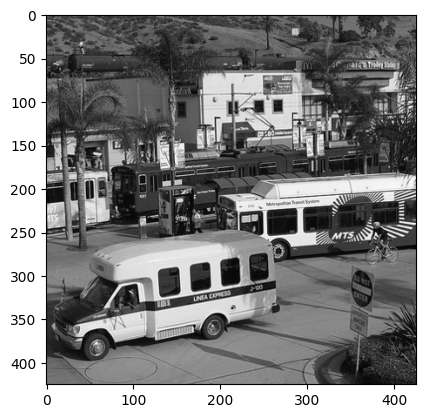

['person' 'bicycle' 'car' 'bus' 'train' 'banner' 'road' 'window-other'
 'tree-merged' 'ceiling-merged' 'sky-other-merged' 'pavement-merged'
 'mountain-merged' 'dirt-merged' 'building-other-merged'
 'wall-other-merged']


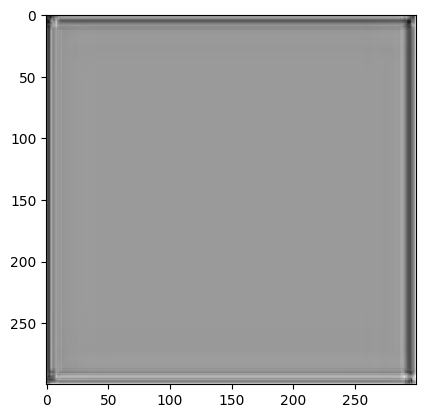

In [30]:
prediction_model1_index = 16
test_data(global_labels_name, global_labels_val[prediction_model1_index], global_images_val[prediction_model1_index], None, None)
test_data(global_labels_name, global_labels_val[prediction_model1_index], prediction_model1[prediction_model1_index], None, None)

In [31]:
## Resize images
size = 200
count = 100
resized_200_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_200_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_200_Y_train_images.shape)

0
50
(100, 200, 200, 1)


In [32]:
encoder2 = keras.models.Sequential()

encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2, input_shape=(200, 200, 1)))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))

encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))
encoder2.summary()

bridge2 = keras.models.Sequential()

bridge2.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, input_shape=(49, 49, 64)))
bridge2.summary()

decoder2 = keras.models.Sequential()

decoder2.add(keras.layers.BatchNormalization(input_shape=(24, 24, 128)))
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2))

decoder2.summary()

model2 = keras.models.Sequential()

model2.add(encoder2)
model2.add(bridge2)
model2.add(decoder2)

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 99, 99, 32)        544       
                                                                 
 batch_normalization_14 (Bat  (None, 99, 99, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 99, 99, 32)        0         
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 49, 49, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (None, 49, 49, 64)       256       
 chNormalization)                                     

In [35]:
#model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.MSE())
#model2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [36]:
model2.fit(expanded_40000_X_train.reshape(-1, 200, 200)[:count], resized_200_Y_train_images, batch_size=64, epochs=60)

Epoch 1/60
2/2 [==============================] - 4s 730ms/step - loss: 0.5789
Epoch 2/60
2/2 [==============================] - 2s 732ms/step - loss: 0.4423
Epoch 3/60
2/2 [==============================] - 2s 739ms/step - loss: 0.3693
Epoch 4/60
2/2 [==============================] - 2s 722ms/step - loss: 0.3308
Epoch 5/60
2/2 [==============================] - 2s 715ms/step - loss: 0.3050
Epoch 6/60
2/2 [==============================] - 2s 731ms/step - loss: 0.2874
Epoch 7/60
2/2 [==============================] - 2s 744ms/step - loss: 0.2746
Epoch 8/60
2/2 [==============================] - 2s 728ms/step - loss: 0.2657
Epoch 9/60
2/2 [==============================] - 2s 729ms/step - loss: 0.2592
Epoch 10/60
2/2 [==============================] - 2s 731ms/step - loss: 0.2547
Epoch 11/60
2/2 [==============================] - 2s 733ms/step - loss: 0.2550
Epoch 12/60
2/2 [==============================] - 2s 735ms/step - loss: 0.2497
Epoch 13/60
2/2 [==============================] 

KeyboardInterrupt: 

In [37]:
prediction_model2 = model2.predict(expanded_40000_X_val.reshape(-1, 200, 200))
print(prediction_model2.shape)

2/2 [==============================] - 0s 128ms/step
(50, 200, 200, 3)


['person' 'motorcycle' 'road' 'fence-merged' 'ceiling-merged'
 'pavement-merged' 'wall-other-merged']


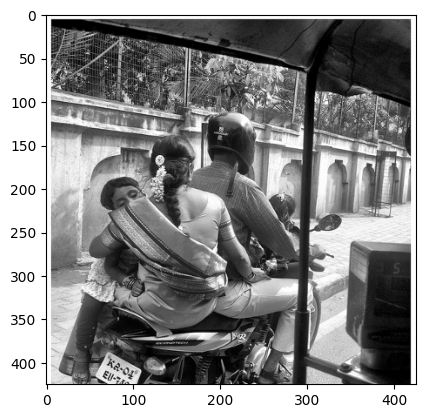

['person' 'motorcycle' 'road' 'fence-merged' 'ceiling-merged'
 'pavement-merged' 'wall-other-merged']


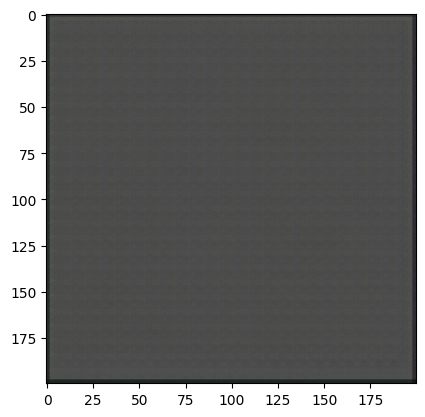

In [38]:
index = 4
test_data(global_labels_name, global_labels_val[index], global_images_val[index], None, None)
test_data(global_labels_name, global_labels_val[index], prediction_model2[index], None, None)